# Hand-drawn shape detection using a neural network

# Abstract

In this notebook we train a neural network to catagorise my own hand drawn shapes labelling each image as either a circle, line or square. The ambitions for this project are two-fold, firstly, my ambition in studying deep learning was to use artificial intelligence to solve my own problems from my own datasets. Secondly, as a rule of thumb, neural networks typically need 1000 examples of each category to successfully train a model. As I do not have the patience to draw 3000 shapes I will be training this neural network using a small number of images (30 per shape) and a variety of data augmentation techniques to expand the dataset to over 3000 examples. The network will then be validated and tested on the remaining images (30 per shape). This emulates a realistic scenario in which data gathering is expensive or time consuming. The neural network is trained in augmented data, however, the network will be validated and tested against non-augmented data, from the original dataset. 

# Contents

<ul>
    <li>Importing and processing augmented dataset</li>
    <li>
        Training neural network
        <ul>
            <li>Defining neural network geometry</li>
            <li>Random hyperparameter search</li>
            <li>Convergence of the cost function</li>
        </ul>
    </li>
    <li>Validation dataset</li>
    <li>Regularisation to prevent overfitting</li>
    <li>Testing neural network</li>
    <li>Conclusion</li>
</ul>

# Importing and processing augmented dataset

In [5]:
from PIL import Image
import numpy as np

Import augmented training dataset. Each image has dimensions 25x25 and hence when flattened has 625 features. We import 3240 images in to a numpy matrix as X with dimensions (3240,625).

In [6]:
num_images = 1080*3
resolu_images = 25**2
file_list = [r"circles\train\circle_",r"lines\train\line_",r"squares\train\square_"]
X = np.zeros([num_images, resolu_images])
counter = 0
for i in range(3):
    for j in range(1080):
        file_name = file_list[i] + str(j+1) + ".jpg"
        X[counter] = np.matrix.flatten(np.array(Image.open(file_name).convert('L')))
        counter += 1
    print("Imported files: {}".format(file_list[i]))

Imported files: circles\train\circle_
Imported files: lines\train\line_
Imported files: squares\train\square_


In [7]:
X.shape

(3240, 625)

Each feature has an RGB value between 0 and 255 which we now normalise.

In [8]:
#Normalise RGB values
X = X / 255

We now define our target class as y with dimensions (3240,1). Each image is either a circle (0), a line (1) or a square (2).

In [9]:
y = np.genfromtxt("train_target_class.csv", delimiter=',')
y = y.reshape((num_images,1))

In [10]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [2.],
       [2.],
       [2.]])

In [11]:
y.shape

(3240, 1)

# Data augmentation

To artificially incraese the amount of training data we can utilise data augmentatio. For each image we flip, rotate, blur and sharpen increasing the original dataset of 90 (30 per shape) to 3240 (1080 per shape). As few exmaples of these are below.

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline 

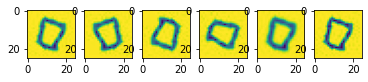

In [45]:
fig, axs = plt.subplots(1,6)
fig_indices = [2160, 2160+30, 2160+60, 2160+120, 3240-720,3240-360]
for i in range(6):
    axs[i].imshow(X[fig_indices[i]].reshape((25,25)))

# Training neural network

### Defining neural network hyperparameters

We now train a neural network on this augmented data. We utilise a softmax neural network which are typically used for catagorisation problems. In this work we will make an initial assumption that a sufficiently sophisticated network can be trained on three layers (two hidden layers). To decide other hyperparameters such as the number of units per layer and the learning rate we perform a random search. We will randomly initialize hyperparameters between sensible limits and see which sets of parameters give timely and controlled minimisation of the cost function.

### Random hyperparameter search

Units in hidden layer 1: Integer value rounded from $10^a$ for $1 \leq a \leq 3$.

Units in hidden layer 2: Integer value rounded from $10^b$ for $-2 \leq b \leq 0$ times the units in hidden layer 1.

Learning rate: Value $\alpha = 10^c$ for $-7 \leq c \leq -1$.

The number of layers in the output layer is fixed to the number of classes (3). We pick the activation function of the hidden layers to be "relu". The activation function of the output layer is linear using logits (equivalent to softmax). For each set of random hyperparameters we plot the loss over 50 epochs. We are looking for hyperparameters that yield a timely yet smooth decrease in loss.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

In [16]:
num_iters = 20
num_epochs = 50
l_1_units_list = []
l_2_units_list = []
l_3_units_list = []
learning_rate_val_list = []
J_list = np.zeros((num_epochs,num_iters))

for k in range(num_iters):    
    np.random.seed(42 + k)
    #Random search of hyperparameters
    l_1_units = int(10**(np.random.rand()*2 + 1))
    l_2_units = int(l_1_units / (10**(0.5 + np.random.rand())))
    l_3_units = int(l_2_units / (10**(0.5 + np.random.rand())))
    learning_rate_val = 10**(-np.random.rand()*3 - 3)
    
    l_1_units_list.append(l_1_units)
    l_2_units_list.append(l_2_units)
    l_3_units_list.append(l_3_units)
    learning_rate_val_list.append(learning_rate_val)
    
    tf.random.set_seed(1234) # for consistent results
    model = Sequential(
        [               
            ### START CODE HERE ### 
            Dense(units=l_1_units, activation='relu'),
            Dense(units=l_2_units, activation='relu'),
            Dense(units=l_3_units, activation='relu'),
            Dense(units=3, activation='linear')
            ### END CODE HERE ### 
        ], name = "my_model" 
    )
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_val),)
    history = model.fit(X, y, epochs=num_epochs)
    J_list[:,k] = history.history['loss']

Epoch 1/50
102/102 [==============================] - 1s 1ms/step - loss: 1.0986
Epoch 2/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 3/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 4/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 5/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 6/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 7/50
102/102 [==============================] - 0s 2ms/step - loss: 1.0986
Epoch 8/50
102/102 [==============================] - 0s 2ms/step - loss: 1.0986
Epoch 9/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 10/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 11/50
102/102 [==============================] - 0s 2ms/step - loss: 1.0986
Epoch 12/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 13/50
102/102 [====

102/102 [==============================] - 1s 4ms/step - loss: 1.0040
Epoch 2/50
102/102 [==============================] - 0s 3ms/step - loss: 0.8484
Epoch 3/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7300
Epoch 4/50
102/102 [==============================] - 0s 3ms/step - loss: 0.6317
Epoch 5/50
102/102 [==============================] - 0s 4ms/step - loss: 0.5489
Epoch 6/50
102/102 [==============================] - 0s 3ms/step - loss: 0.4923
Epoch 7/50
102/102 [==============================] - 0s 3ms/step - loss: 0.4420
Epoch 8/50
102/102 [==============================] - 0s 3ms/step - loss: 0.4017
Epoch 9/50
102/102 [==============================] - 0s 3ms/step - loss: 0.3598
Epoch 10/50
102/102 [==============================] - 0s 3ms/step - loss: 0.3426
Epoch 11/50
102/102 [==============================] - 0s 3ms/step - loss: 0.3116
Epoch 12/50
102/102 [==============================] - 0s 3ms/step - loss: 0.2858
Epoch 13/50
102/102 [===============

102/102 [==============================] - 0s 802us/step - loss: 1.0986
Epoch 1/50
102/102 [==============================] - 0s 833us/step - loss: 1.0986
Epoch 2/50
102/102 [==============================] - 0s 776us/step - loss: 1.0986
Epoch 3/50
102/102 [==============================] - 0s 771us/step - loss: 1.0986
Epoch 4/50
102/102 [==============================] - 0s 741us/step - loss: 1.0986
Epoch 5/50
102/102 [==============================] - 0s 813us/step - loss: 1.0986
Epoch 6/50
102/102 [==============================] - 0s 809us/step - loss: 1.0986
Epoch 7/50
102/102 [==============================] - 0s 801us/step - loss: 1.0986
Epoch 8/50
102/102 [==============================] - 0s 852us/step - loss: 1.0986
Epoch 9/50
102/102 [==============================] - 0s 823us/step - loss: 1.0986
Epoch 10/50
102/102 [==============================] - 0s 776us/step - loss: 1.0986
Epoch 11/50
102/102 [==============================] - 0s 823us/step - loss: 1.0986
Epoch 12/50
1

102/102 [==============================] - 0s 2ms/step - loss: 0.4027
Epoch 48/50
102/102 [==============================] - 0s 2ms/step - loss: 0.3975
Epoch 49/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3912
Epoch 50/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3856
Epoch 1/50
102/102 [==============================] - 1s 3ms/step - loss: 1.0697
Epoch 2/50
102/102 [==============================] - 0s 3ms/step - loss: 0.9676
Epoch 3/50
102/102 [==============================] - 0s 3ms/step - loss: 0.9054
Epoch 4/50
102/102 [==============================] - 0s 3ms/step - loss: 0.8577
Epoch 5/50
102/102 [==============================] - 0s 3ms/step - loss: 0.8168
Epoch 6/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7785
Epoch 7/50
102/102 [==============================] - 0s 3ms/step - loss: 0.7353
Epoch 8/50
102/102 [==============================] - 0s 3ms/step - loss: 0.6971
Epoch 9/50
102/102 [================

102/102 [==============================] - 0s 985us/step - loss: 1.0986
Epoch 47/50
102/102 [==============================] - 0s 843us/step - loss: 1.0986
Epoch 48/50
102/102 [==============================] - 0s 866us/step - loss: 1.0986
Epoch 49/50
102/102 [==============================] - 0s 830us/step - loss: 1.0986
Epoch 50/50
102/102 [==============================] - 0s 908us/step - loss: 1.0986
Epoch 1/50
102/102 [==============================] - 1s 5ms/step - loss: 0.8409
Epoch 2/50
102/102 [==============================] - 1s 5ms/step - loss: 0.6138
Epoch 3/50
102/102 [==============================] - 1s 6ms/step - loss: 0.4950
Epoch 4/50
102/102 [==============================] - 1s 5ms/step - loss: 0.4411
Epoch 5/50
102/102 [==============================] - 1s 5ms/step - loss: 0.3742
Epoch 6/50
102/102 [==============================] - 1s 5ms/step - loss: 0.3345
Epoch 7/50
102/102 [==============================] - 1s 5ms/step - loss: 0.2865
Epoch 8/50
102/102 [=====

Epoch 46/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 47/50
102/102 [==============================] - 0s 981us/step - loss: 1.0986
Epoch 48/50
102/102 [==============================] - 0s 923us/step - loss: 1.0986
Epoch 49/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 50/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 1/50
102/102 [==============================] - 0s 995us/step - loss: 1.0986
Epoch 2/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 3/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 4/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 5/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 6/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 7/50
102/102 [==============================] - 0s 1ms/step - loss: 1.0986
Epoch 8/50
102/10

102/102 [==============================] - 0s 4ms/step - loss: 1.0987
Epoch 47/50
102/102 [==============================] - 0s 4ms/step - loss: 1.0987
Epoch 48/50
102/102 [==============================] - 0s 4ms/step - loss: 1.0987
Epoch 49/50
102/102 [==============================] - 0s 4ms/step - loss: 1.0986
Epoch 50/50
102/102 [==============================] - 0s 4ms/step - loss: 1.0987
Epoch 1/50
102/102 [==============================] - 0s 906us/step - loss: 1.1162
Epoch 2/50
102/102 [==============================] - 0s 886us/step - loss: 1.0995
Epoch 3/50
102/102 [==============================] - 0s 899us/step - loss: 1.0991
Epoch 4/50
102/102 [==============================] - 0s 987us/step - loss: 1.0990
Epoch 5/50
102/102 [==============================] - 0s 940us/step - loss: 1.0988
Epoch 6/50
102/102 [==============================] - 0s 997us/step - loss: 1.0988
Epoch 7/50
102/102 [==============================] - 0s 980us/step - loss: 1.0987
Epoch 8/50
102/102 [=

Out of each set of hyperparameters it seems that set 10 provides a steady yet timely decrease in the cost function.

In [47]:
marker_list = ["o","s","^","|"]
for k in range(num_iters):
    plt.plot(J_list[:,k], label = "Params: {}".format(k), marker=marker_list[k % 4])
    plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.ylabel("Cost function"), plt.xlabel("Epochs")

NameError: name 'num_iters' is not defined

In [21]:
k = 10
print("For parameters k={}: layer 1 has {} units, layer 2 has {} units and layer 3 has {} units.".format(k, l_1_units_list[k], l_2_units_list[k], l_3_units_list[k]))
print("For parameters k={}: the learning rate is {}.".format(k, learning_rate_val_list[k], l_2_units_list[k]))

For parameters k=10: layer 1 has 442 units, layer 2 has 131 units and layer 3 has 25 units.
For parameters k=10: the learning rate is 1.3955155880057205e-05.


### Convergence of the cost function

Lets test convergence over more epochs.

In [22]:
num_epochs = 500    
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        Dense(units=442, activation='relu'),
        Dense(units=131, activation='relu'),
        Dense(units=25, activation='relu'),
        Dense(units=3, activation='linear')
        ### END CODE HERE ### 
    ], name = "my_model" 
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1.29e-05),)
history = model.fit(X, y, epochs=num_epochs)
J = history.history['loss']

Epoch 1/500
102/102 [==============================] - 1s 4ms/step - loss: 1.0747
Epoch 2/500
102/102 [==============================] - 0s 4ms/step - loss: 0.9768
Epoch 3/500
102/102 [==============================] - 0s 3ms/step - loss: 0.9155
Epoch 4/500
102/102 [==============================] - 0s 3ms/step - loss: 0.8688
Epoch 5/500
102/102 [==============================] - 0s 3ms/step - loss: 0.8284
Epoch 6/500
102/102 [==============================] - 0s 3ms/step - loss: 0.7905
Epoch 7/500
102/102 [==============================] - 1s 5ms/step - loss: 0.7480
Epoch 8/500
102/102 [==============================] - 0s 3ms/step - loss: 0.7125
Epoch 9/500
102/102 [==============================] - 0s 3ms/step - loss: 0.6806
Epoch 10/500
102/102 [==============================] - 0s 3ms/step - loss: 0.6529
Epoch 11/500
102/102 [==============================] - 0s 3ms/step - loss: 0.6234
Epoch 12/500
102/102 [==============================] - 0s 4ms/step - loss: 0.5951
Epoch 13/500


102/102 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 197/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 198/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 199/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 200/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 201/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 202/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 203/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 204/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 205/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 206/500
102/102 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 207/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 

102/102 [==============================] - 0s 3ms/step - loss: 1.2693e-04
Epoch 387/500
102/102 [==============================] - 0s 3ms/step - loss: 1.2246e-04
Epoch 388/500
102/102 [==============================] - 0s 3ms/step - loss: 1.1793e-04
Epoch 389/500
102/102 [==============================] - 0s 3ms/step - loss: 1.1475e-04
Epoch 390/500
102/102 [==============================] - 0s 3ms/step - loss: 1.1062e-04
Epoch 391/500
102/102 [==============================] - 0s 3ms/step - loss: 1.0926e-04
Epoch 392/500
102/102 [==============================] - 0s 3ms/step - loss: 1.0479e-04
Epoch 393/500
102/102 [==============================] - 0s 3ms/step - loss: 1.0273e-04
Epoch 394/500
102/102 [==============================] - 0s 3ms/step - loss: 1.0066e-04
Epoch 395/500
102/102 [==============================] - 0s 3ms/step - loss: 9.8144e-05
Epoch 396/500
102/102 [==============================] - 0s 3ms/step - loss: 9.6188e-05
Epoch 397/500
102/102 [=======================

We reach convergence in the cost function in 500 epochs!

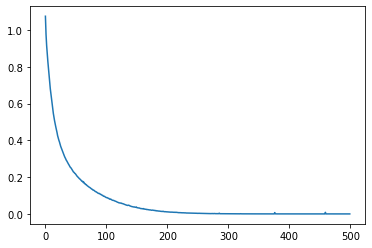

In [23]:
plt.plot(J)

In [24]:
prediction = model.predict(X)
prediction_p = tf.nn.softmax(prediction)
y_hat = np.zeros((len(prediction_p),1))
for i in range(len(y_hat)):
    y_hat[i] = np.argmax(prediction_p[i])
plt.ylabel("Cost function"), plt.xlabel("Epochs")

102/102 [==============================] - 0s 2ms/step


We can see that our neural network predicts the test data we get an accuracy of 100%. This tells us that our model is sufficiently large enough to predict such results. If we could not reach high accuracy on training data we would need to increase the size of the network.

In [25]:
np.sum(y_hat == y)/len(y)

1.0

# Validation dataset

Lets load in our validation dataset. Note that our validation data is raw data and not augmented like our training data.

In [27]:
num_images = 15*3
resolu_images = 25**2
file_list = [r"circles\valid\circle_",r"lines\valid\line_",r"squares\valid\square_"]
X_valid = np.zeros([num_images, resolu_images])
counter = 0
for i in range(3):
    for j in range(15):
        file_name = file_list[i] + str(j+1) + ".jpg"
        X_valid[counter] = np.matrix.flatten(np.array(Image.open(file_name).convert('L')))
        counter += 1
    print("Imported files: {}".format(file_list[i]))

Imported files: circles\valid\circle_
Imported files: lines\valid\line_
Imported files: squares\valid\square_


Normalise validation data.

In [28]:
X_valid = X_valid / 255

In [29]:
X_valid.shape

(45, 625)

In [30]:
y_valid = np.genfromtxt("valid_target_class.csv", delimiter=',')
y_valid = y_valid.reshape((num_images,1))

In [31]:
y_valid.shape

(45, 1)

In [32]:
prediction_valid = model.predict(X_valid)
prediction_valid_p = tf.nn.softmax(prediction_valid)
y_hat_valid = np.zeros((len(prediction_valid_p),1))
for i in range(len(y_hat_valid)):
    y_hat_valid[i] = np.argmax(prediction_valid_p[i])

2/2 [==============================] - 0s 5ms/step


In [33]:
np.sum(y_hat_valid == y_valid)/len(y_valid)

0.8888888888888888

We actually achieve 89% accuracy on our validation data which is good considering we have not yet adjusted for overfitting to our training data.

# Regularisation to prevent overfitting

To prevent overfitting to the test dataset we utilise L2 regularisation. Lets perform a grid search with varying degrees of L2 regularisation to try and increase our validation dataset accuracy at the expense of training dataset accuracy.

We vary the amount of L2 regularisation with values $10^d$ where $d = [-3, -2.5, -2, -1.5, -1, -0.5, 0]$. Then the neural network is trained on the training dataset towards convergence (~300 epochs). Then the training dataset accuracy is compared to the test dataset accuracy.

In [35]:
l2_reg_val_list = 10**np.arange(-3,0,0.5)
num_iters = len(l2_reg_val_list)
num_epochs = 300
J_list = np.zeros((num_epochs,num_iters))
train_precision = []
valid_precision = []
counter = 0
for l2_reg_val in l2_reg_val_list:    
    np.random.seed(42 + k)
    
    
    tf.random.set_seed(1234) # for consistent results
    model = Sequential(
        [               
            ### START CODE HERE ### 
            Dense(units=442, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=131, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=25, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=4, activation='linear',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val))
            ### END CODE HERE ### 
        ], name = "my_model" 
    )
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=3*(10**(-5))),)
    history = model.fit(X, y, epochs=num_epochs)
    J_list[:,counter] = history.history['loss']
    counter +=1
    prediction_train = model.predict(X)
    prediction_train_p = tf.nn.softmax(prediction_train)
    y_hat_train = np.zeros((len(prediction_train_p),1))
    for i in range(len(y_hat_train)):
        y_hat_train[i] = np.argmax(prediction_train_p[i])
    train_precision.append(np.sum(y_hat_train==y)/len(y_hat_train))
    
    prediction_valid = model.predict(X_valid)
    prediction_valid_p = tf.nn.softmax(prediction_valid)
    y_hat_valid = np.zeros((len(prediction_valid_p),1))
    for i in range(len(y_hat_valid)):
        y_hat_valid[i] = np.argmax(prediction_valid_p[i])
    valid_precision.append(np.sum(y_hat_valid==y_valid)/len(y_valid))

Epoch 1/300
102/102 [==============================] - 1s 5ms/step - loss: 1.3298
Epoch 2/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0418
Epoch 3/300
102/102 [==============================] - 1s 6ms/step - loss: 0.9163
Epoch 4/300
102/102 [==============================] - 1s 7ms/step - loss: 0.8216
Epoch 5/300
102/102 [==============================] - 1s 10ms/step - loss: 0.7530
Epoch 6/300
102/102 [==============================] - 1s 7ms/step - loss: 0.6912
Epoch 7/300
102/102 [==============================] - 1s 7ms/step - loss: 0.6424
Epoch 8/300
102/102 [==============================] - 1s 6ms/step - loss: 0.5974
Epoch 9/300
102/102 [==============================] - 1s 5ms/step - loss: 0.5527
Epoch 10/300
102/102 [==============================] - 0s 4ms/step - loss: 0.5211
Epoch 11/300
102/102 [==============================] - 1s 5ms/step - loss: 0.4894
Epoch 12/300
102/102 [==============================] - 1s 5ms/step - loss: 0.4614
Epoch 13/300

102/102 [==============================] - 0s 4ms/step - loss: 0.0426
Epoch 197/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0426
Epoch 198/300
102/102 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 199/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 200/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 201/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0602
Epoch 202/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0665
Epoch 203/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0446
Epoch 204/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0435
Epoch 205/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0430
Epoch 206/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 207/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0426
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.1246
Epoch 91/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1235
Epoch 92/300
102/102 [==============================] - 1s 5ms/step - loss: 0.1230
Epoch 93/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1221
Epoch 94/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1210
Epoch 95/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1204
Epoch 96/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1197
Epoch 97/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1196
Epoch 98/300
102/102 [==============================] - 1s 6ms/step - loss: 0.1186
Epoch 99/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1183
Epoch 100/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1176
Epoch 101/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1169
Epoch 102/300
1

102/102 [==============================] - 0s 4ms/step - loss: 0.0869
Epoch 285/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0869
Epoch 286/300
102/102 [==============================] - 0s 5ms/step - loss: 0.0868
Epoch 287/300
102/102 [==============================] - 0s 5ms/step - loss: 0.0868
Epoch 288/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0868
Epoch 289/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0867
Epoch 290/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0867
Epoch 291/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0867
Epoch 292/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0866
Epoch 293/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0866
Epoch 294/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0865
Epoch 295/300
102/102 [==============================] - 0s 4ms/step - loss: 0.0865
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.1984
Epoch 179/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1982
Epoch 180/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1984
Epoch 181/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1979
Epoch 182/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1977
Epoch 183/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1977
Epoch 184/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1975
Epoch 185/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1971
Epoch 186/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1968
Epoch 187/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1973
Epoch 188/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1964
Epoch 189/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1964
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.4730
Epoch 73/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4708
Epoch 74/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4689
Epoch 75/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4669
Epoch 76/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4654
Epoch 77/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4637
Epoch 78/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4622
Epoch 79/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4604
Epoch 80/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4590
Epoch 81/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4580
Epoch 82/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4564
Epoch 83/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4548
Epoch 84/300
102/

102/102 [==============================] - 0s 4ms/step - loss: 0.3931
Epoch 171/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3931
Epoch 172/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3926
Epoch 173/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3920
Epoch 174/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3918
Epoch 175/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3914
Epoch 176/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3908
Epoch 177/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3908
Epoch 178/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3902
Epoch 179/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3899
Epoch 180/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3893
Epoch 181/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3902
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.8293
Epoch 65/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8266
Epoch 66/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8241
Epoch 67/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8214
Epoch 68/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8184
Epoch 69/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8156
Epoch 70/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8131
Epoch 71/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8110
Epoch 72/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8087
Epoch 73/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8065
Epoch 74/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8038
Epoch 75/300
102/102 [==============================] - 0s 5ms/step - loss: 0.8019
Epoch 76/300
102/

102/102 [==============================] - 0s 4ms/step - loss: 0.7027
Epoch 163/300
102/102 [==============================] - 0s 4ms/step - loss: 0.7017
Epoch 164/300
102/102 [==============================] - 0s 4ms/step - loss: 0.7008
Epoch 165/300
102/102 [==============================] - 0s 4ms/step - loss: 0.7004
Epoch 166/300
102/102 [==============================] - 0s 4ms/step - loss: 0.7002
Epoch 167/300
102/102 [==============================] - 0s 4ms/step - loss: 0.7003
Epoch 168/300
102/102 [==============================] - 0s 4ms/step - loss: 0.7003
Epoch 169/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6978
Epoch 170/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6982
Epoch 171/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6973
Epoch 172/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6972
Epoch 173/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6963
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 1.2410
Epoch 57/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2373
Epoch 58/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2342
Epoch 59/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2294
Epoch 60/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2260
Epoch 61/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2231
Epoch 62/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2198
Epoch 63/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2153
Epoch 64/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2134
Epoch 65/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2098
Epoch 66/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2068
Epoch 67/300
102/102 [==============================] - 0s 4ms/step - loss: 1.2028
Epoch 68/300
102/

102/102 [==============================] - 0s 4ms/step - loss: 1.0176
Epoch 252/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0177
Epoch 253/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0179
Epoch 254/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0172
Epoch 255/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0176
Epoch 256/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0179
Epoch 257/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0171
Epoch 258/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0164
Epoch 259/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0181
Epoch 260/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0183
Epoch 261/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0159
Epoch 262/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0162
Epoch 

We see a small increase in the validation dataset for L2 regularisation with srength 0.01, lets explore values around this number. 

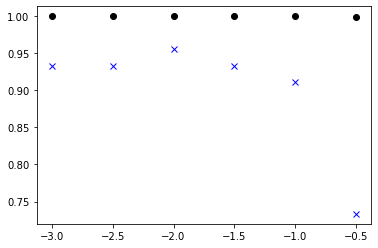

In [36]:
plt.plot(np.log10(l2_reg_val_list),train_precision,'ko',label="train precision")
plt.plot(np.log10(l2_reg_val_list),valid_precision,'bx',label="validate precision")
plt.ylabel("Cost function"), plt.xlabel("log(L2)")

Now we vary the L2 parameter strength as $10^d$ where for $d$ between $-2.375$ and $-1.5$.

In [63]:
l2_reg_val_list = 10**np.arange(-2.375,-1.5,0.125)
num_iters = len(l2_reg_val_list)
num_epochs = 300
J_list = np.zeros((num_epochs,num_iters))
train_precision = []
valid_precision = []
counter = 0
for l2_reg_val in l2_reg_val_list:    
    np.random.seed(42 + k)
    
    
    tf.random.set_seed(1234) # for consistent results
    model = Sequential(
        [               
            ### START CODE HERE ### 
            Dense(units=442, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=131, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=25, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=4, activation='linear',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val))
            ### END CODE HERE ### 
        ], name = "my_model" 
    )
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=3*(10**(-5))),)
    history = model.fit(X, y, epochs=num_epochs)
    J_list[:,counter] = history.history['loss']
    counter +=1
    prediction_train = model.predict(X)
    prediction_train_p = tf.nn.softmax(prediction_train)
    y_hat_train = np.zeros((len(prediction_train_p),1))
    for i in range(len(y_hat_train)):
        y_hat_train[i] = np.argmax(prediction_train_p[i])
    train_precision.append(np.sum(y_hat_train==y)/len(y_hat_train))
    
    prediction_valid = model.predict(X_valid)
    prediction_valid_p = tf.nn.softmax(prediction_valid)
    y_hat_valid = np.zeros((len(prediction_valid_p),1))
    for i in range(len(y_hat_valid)):
        y_hat_valid[i] = np.argmax(prediction_valid_p[i])
    valid_precision.append(np.sum(y_hat_valid==y_valid)/len(y_valid))

Epoch 1/300
102/102 [==============================] - 1s 4ms/step - loss: 1.7417
Epoch 2/300
102/102 [==============================] - 1s 5ms/step - loss: 1.1660
Epoch 3/300
102/102 [==============================] - 0s 5ms/step - loss: 1.0307
Epoch 4/300
102/102 [==============================] - 0s 4ms/step - loss: 0.9454
Epoch 5/300
102/102 [==============================] - 0s 4ms/step - loss: 0.8793
Epoch 6/300
102/102 [==============================] - 1s 5ms/step - loss: 0.8196
Epoch 7/300
102/102 [==============================] - 0s 5ms/step - loss: 0.7654
Epoch 8/300
102/102 [==============================] - 0s 4ms/step - loss: 0.7187
Epoch 9/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6748
Epoch 10/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6401
Epoch 11/300
102/102 [==============================] - 0s 4ms/step - loss: 0.6066
Epoch 12/300
102/102 [==============================] - 0s 4ms/step - loss: 0.5761
Epoch 13/300


102/102 [==============================] - 0s 4ms/step - loss: 0.1116
Epoch 197/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1116
Epoch 198/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1118
Epoch 199/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1115
Epoch 200/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 201/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 202/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 203/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1110
Epoch 204/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1107
Epoch 205/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 206/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1113
Epoch 207/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1105
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.1736
Epoch 91/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1721
Epoch 92/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1712
Epoch 93/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1703
Epoch 94/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1695
Epoch 95/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1688
Epoch 96/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1676
Epoch 97/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1670
Epoch 98/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1663
Epoch 99/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1655
Epoch 100/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1650
Epoch 101/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1642
Epoch 102/300
1

102/102 [==============================] - 0s 4ms/step - loss: 0.1280
Epoch 285/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1280
Epoch 286/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1279
Epoch 287/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1279
Epoch 288/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1278
Epoch 289/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1277
Epoch 290/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1277
Epoch 291/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1276
Epoch 292/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1276
Epoch 293/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1275
Epoch 294/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1275
Epoch 295/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1274
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.1657
Epoch 179/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1665
Epoch 180/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1672
Epoch 181/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1682
Epoch 182/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1673
Epoch 183/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1648
Epoch 184/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1643
Epoch 185/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1642
Epoch 186/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1640
Epoch 187/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1638
Epoch 188/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1637
Epoch 189/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1635
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.2607
Epoch 73/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2592
Epoch 74/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2577
Epoch 75/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2560
Epoch 76/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2548
Epoch 77/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2538
Epoch 78/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2519
Epoch 79/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2510
Epoch 80/300
102/102 [==============================] - 0s 5ms/step - loss: 0.2497
Epoch 81/300
102/102 [==============================] - 0s 5ms/step - loss: 0.2488
Epoch 82/300
102/102 [==============================] - 1s 5ms/step - loss: 0.2476
Epoch 83/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2462
Epoch 84/300
102/

102/102 [==============================] - 0s 4ms/step - loss: 0.2001
Epoch 171/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2000
Epoch 172/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1998
Epoch 173/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1997
Epoch 174/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1994
Epoch 175/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1991
Epoch 176/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1989
Epoch 177/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1988
Epoch 178/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1984
Epoch 179/300
102/102 [==============================] - 0s 3ms/step - loss: 0.1982
Epoch 180/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1984
Epoch 181/300
102/102 [==============================] - 0s 4ms/step - loss: 0.1979
Epoch 

102/102 [==============================] - 0s 3ms/step - loss: 0.3169
Epoch 65/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3147
Epoch 66/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3137
Epoch 67/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3111
Epoch 68/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3090
Epoch 69/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3079
Epoch 70/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3060
Epoch 71/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3045
Epoch 72/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3036
Epoch 73/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3016
Epoch 74/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2998
Epoch 75/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2981
Epoch 76/300
102/

102/102 [==============================] - 0s 3ms/step - loss: 0.2406
Epoch 163/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2403
Epoch 164/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2403
Epoch 165/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2397
Epoch 166/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2399
Epoch 167/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2398
Epoch 168/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2389
Epoch 169/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2387
Epoch 170/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2390
Epoch 171/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2384
Epoch 172/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2383
Epoch 173/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2384
Epoch 

102/102 [==============================] - 0s 4ms/step - loss: 0.3864
Epoch 57/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3836
Epoch 58/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3810
Epoch 59/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3783
Epoch 60/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3763
Epoch 61/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3744
Epoch 62/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3718
Epoch 63/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3699
Epoch 64/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3682
Epoch 65/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3654
Epoch 66/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3640
Epoch 67/300
102/102 [==============================] - 0s 4ms/step - loss: 0.3614
Epoch 68/300
102/

102/102 [==============================] - 0s 4ms/step - loss: 0.2944
Epoch 252/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2756
Epoch 253/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2717
Epoch 254/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2703
Epoch 255/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2696
Epoch 256/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2696
Epoch 257/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2691
Epoch 258/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2688
Epoch 259/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2687
Epoch 260/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2684
Epoch 261/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2683
Epoch 262/300
102/102 [==============================] - 0s 3ms/step - loss: 0.2681
Epoch 

102/102 [==============================] - 0s 3ms/step - loss: 0.4708
Epoch 49/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4668
Epoch 50/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4631
Epoch 51/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4599
Epoch 52/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4569
Epoch 53/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4534
Epoch 54/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4503
Epoch 55/300
102/102 [==============================] - 0s 4ms/step - loss: 0.4477
Epoch 56/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4445
Epoch 57/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4417
Epoch 58/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4390
Epoch 59/300
102/102 [==============================] - 0s 3ms/step - loss: 0.4363
Epoch 60/300
102/

102/102 [==============================] - 0s 3ms/step - loss: 0.3193
Epoch 244/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3191
Epoch 245/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3192
Epoch 246/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3188
Epoch 247/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3187
Epoch 248/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3189
Epoch 249/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3193
Epoch 250/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3246
Epoch 251/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3355
Epoch 252/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3317
Epoch 253/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3208
Epoch 254/300
102/102 [==============================] - 0s 3ms/step - loss: 0.3196
Epoch 

We see quite large variation in the validation dataset accuracy for small changes in the L2 regularisation strength. This variation is likely demonstrating that our dataset is on the small side. For example, when $d$ is $-1.875$ we obtain 42/45 correct solutions whilst when $d$ is $-1.75$ we get 45/45 correct. If we had more data this variation would smooth out.

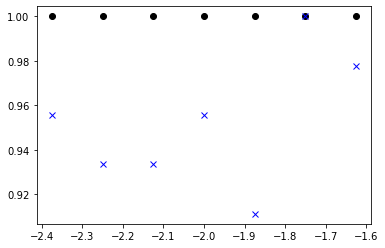

In [64]:
plt.plot(np.log10(l2_reg_val_list),train_precision,'ko',label="train precision")
plt.plot(np.log10(l2_reg_val_list),valid_precision,'bx',label="validate precision")
plt.ylabel("Cost function"), plt.xlabel("log(L2)")

Nevertheless, we will proceed with the best value of $d =  -1.75$. A note will be made that more data is needed for a validation test set. This project was meant to emulate an situation where data gathering is expensive - perhaps more of the original data should be used for validation and testing and a smaller mount of data augmented for training.

# Testing neural network

Lets import our test dataset, normalise it and test our neural network.

In [65]:
num_images = 15*3
resolu_images = 25**2
file_list = [r"circles\test\circle_",r"lines\test\line_",r"squares\test\square_"]
X_test = np.zeros([num_images, resolu_images])
counter = 0
for i in range(3):
    for j in range(15):
        file_name = file_list[i] + str(j+1) + ".jpg"
        X_test[counter] = np.matrix.flatten(np.array(Image.open(file_name).convert('L')))
        counter += 1
    print("Imported files: {}".format(file_list[i]))

Imported files: circles\test\circle_
Imported files: lines\test\line_
Imported files: squares\test\square_


In [66]:
X_test = X_test / 255

In [67]:
y_test = np.genfromtxt("test_target_class.csv", delimiter=',')
y_test = y_test.reshape((num_images,1))

In [68]:
num_epochs = 300    
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        Dense(units=442, activation='relu',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75))),
        Dense(units=131, activation='relu',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75))),
        Dense(units=25, activation='relu',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75))),
        Dense(units=3, activation='linear',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75)))
        ### END CODE HERE ### 
    ], name = "my_model" 
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1.29e-05),)
history = model.fit(X, y, epochs=num_epochs)
J = history.history['loss']

Epoch 1/300
102/102 [==============================] - 1s 4ms/step - loss: 4.1088
Epoch 2/300
102/102 [==============================] - 0s 4ms/step - loss: 2.0848
Epoch 3/300
102/102 [==============================] - 0s 3ms/step - loss: 1.4548
Epoch 4/300
102/102 [==============================] - 0s 3ms/step - loss: 1.2198
Epoch 5/300
102/102 [==============================] - 0s 5ms/step - loss: 1.1252
Epoch 6/300
102/102 [==============================] - 1s 5ms/step - loss: 1.0823
Epoch 7/300
102/102 [==============================] - 1s 5ms/step - loss: 1.0570
Epoch 8/300
102/102 [==============================] - 0s 4ms/step - loss: 1.0371
Epoch 9/300
102/102 [==============================] - 0s 3ms/step - loss: 1.0181
Epoch 10/300
102/102 [==============================] - 0s 3ms/step - loss: 1.0001
Epoch 11/300
102/102 [==============================] - 0s 3ms/step - loss: 0.9830
Epoch 12/300
102/102 [==============================] - 0s 3ms/step - loss: 0.9652
Epoch 13/300


102/102 [==============================] - 1s 5ms/step - loss: 0.2656
Epoch 197/300
102/102 [==============================] - 0s 5ms/step - loss: 0.2652
Epoch 198/300
102/102 [==============================] - 0s 5ms/step - loss: 0.2648
Epoch 199/300
102/102 [==============================] - 1s 5ms/step - loss: 0.2644
Epoch 200/300
102/102 [==============================] - 1s 5ms/step - loss: 0.2640
Epoch 201/300
102/102 [==============================] - 0s 5ms/step - loss: 0.2636
Epoch 202/300
102/102 [==============================] - 1s 5ms/step - loss: 0.2632
Epoch 203/300
102/102 [==============================] - 1s 5ms/step - loss: 0.2628
Epoch 204/300
102/102 [==============================] - 1s 5ms/step - loss: 0.2623
Epoch 205/300
102/102 [==============================] - 0s 5ms/step - loss: 0.2620
Epoch 206/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2616
Epoch 207/300
102/102 [==============================] - 0s 4ms/step - loss: 0.2612
Epoch 

In [69]:
prediction_test = model.predict(X_test)
prediction_test_p = tf.nn.softmax(prediction_test)
y_hat_test = np.zeros((len(prediction_test_p),1))
for i in range(len(y_hat_test)):
    y_hat_test[i] = np.argmax(prediction_test_p[i])

2/2 [==============================] - 0s 2ms/step


We obtain an accuracy of 93% - this is better than we obtained on our validation dataset. Due to the small amoutn of validation and test examples we can't say with certainty how effective regularisation was.

In [70]:
np.sum(y_hat_test == y_test)/len(y_test)

0.9333333333333333

We got 3/45 examples wrong. 

In [72]:
np.sum(y_hat_test != y_test)

3

Plotting the three incorrectly classified images we see that three squares (2) were incorrectly catagorised as circles (0). The first and third incorrect images are slightly rounded, which may have confused the newtork. Perhaps higher resolution images would have aided this classification. Nevertheless, I do believe a human would be able to correctly label these results as squares meaning in this case the network is performing under baseline performance. The second result is less concerning. I believe the protruding line from the square means this image is an outlier.

In [73]:
incorrect_index = np.where(y_hat_test != y_test)[0]

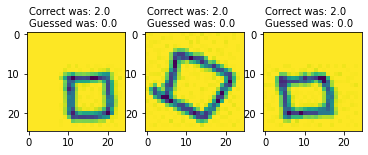

In [86]:
fig, axs = plt.subplots(1,3)
for i in range(3):
    axs[i].imshow(X_test[incorrect_index[i]].reshape((25,25)))
    axs[i].text(0,-5,"Correct was: {}".format(y_test[incorrect_index[i],0]))
    axs[i].text(0,-2,"Guessed was: {}".format(y_hat_test[incorrect_index[i],0]))

# Conclusion

To summarise, from only 180 original images we have successfully trained a neural network that can successfully distinguish lines and shapes and is over 90% successful at distinguishing low-resolution circles and squares. 

To train a more effective model several improvements could be made. More data should we including in the validation dataset, this would allow more effective tuning of the regularisation parameter which would prevent overfitting to the heavily augmented trainign dataset. 

Perhaps two validation datasets could be made - the first from the augmented dataset and the second from the non-augmented dataset. The augmeted validation set could be used to tune regularisaition that can prevent overfitting within the augmented dataset. The second, non-augmented validation dataset could instead be used to prevent overfitting to the augmented dataset. To explain this example in simple terms, imagine we trained a neural network to distinguish cats and dogs. Lets imagine we took a small selection of 15 cats from a dataset of 45 cats - to train the neural model we then augmented the training dataset by flipping, rotating and further modifying images. If in the original dataset, 14 of the 15 cats had black fur, then in the augmented training set 90% of thousands of cat examples might have black fur leading the neural network to strongly associate black fur with cats -  when in truth maybe only 50% of cats have black fur. This would be overfitting to the dataset.     

To further improve this work it may also be recommended to use a convolution neural network that could more quickly process high resolution images.